In [1]:
from scipy.integrate import odeint
from scipy.stats import lognorm
import numpy as np
from ode_api import *
from ode_funcs import *
import matplotlib.pyplot as plt
import scipy
import pymc3 as pm

THEANO_FLAGS = 'exception_verbosity=high'

# Test: Vector ODE with 1 parameter

$$ S'= -R_0 S I \quad S(0) = 0.99 $$

$$ I' = R_0 S I - I \quad I(0) = 0.01 $$

In [2]:
#Specify how many stats, initial values, and ode parameters there are
n_states = 2
n_ics = 2
n_odeparams = 1

#Times to evaluate the solution
times = np.arange(0.25,6,0.5)

#Instantiate the ODEModel
model_1 = ODEModel(odefunc = test_ode_func_3, 
                   t0 = 0,
                    times = times,
                    n_states = n_states,
                    n_ics = n_ics,
                    n_odeparams = n_odeparams)

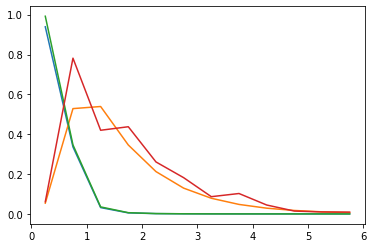

In [3]:
#Simulate the data and create data to learn from
sims, sens = model_1.simulate([8, 0.99,0.01])


S = scipy.stats.lognorm.rvs(s = 0.1, scale = sims[:,0])
I = scipy.stats.lognorm.rvs(s = 0.25, scale = sims[:,1])

Y = np.vstack([S,I]).T

plt.plot(times, sims)

plt.plot(times, Y);

In [4]:
# Now instantiate the theano custom ODE op
my_ODEop = ODEop(model_1)

all_params __str__ = [1.  0.9 0.1]
ode_sol __str__ = [0.87807092 0.09726168 0.83774144 0.09057331 0.80218669 0.08275991
 0.7712745  0.07437508 0.74470105 0.06588705 0.72206416 0.05765508
 0.70291997 0.04992831 0.6868224  0.04285858 0.67334805 0.03651954
 0.66210992 0.0309269  0.65276352 0.02605664 0.64500793 0.02185992]
forward __str__ = [[-0.13002791 -2.33035018]
 [-0.17704577 -2.40159575]
 [-0.22041391 -2.49181153]
 [-0.25971093 -2.59863435]
 [-0.29477241 -2.71981337]
 [-0.32564128 -2.85327698]
 [-0.35251224 -2.99716709]
 [-0.37567953 -3.14984938]
 [-0.39549292 -3.30990769]
 [-0.41232369 -3.47612886]
 [-0.42654035 -3.64748273]
 [-0.43849266 -3.82310044]]


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, S0, R]
Sampling 4 chains: 100%|██████████| 12000/12000 [40:33<00:00,  1.72draws/s] 
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


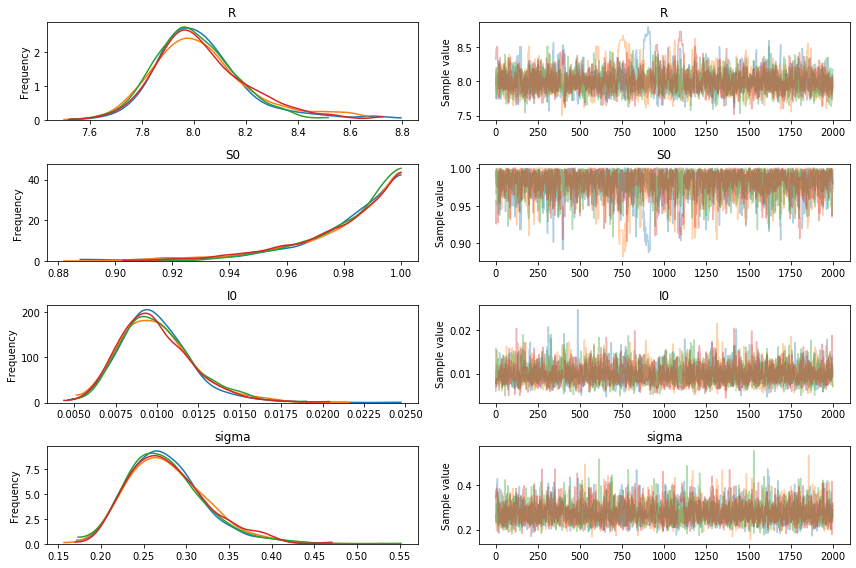

In [5]:
# The probabilistic model
with pm.Model() as first_model:

    # Priors for unknown model parameters
    R = pm.HalfCauchy('R', 1)

    S0 = pm.Beta('S0',9,1)
    I0 = pm.Beta('I0',1,9)
    sigma = pm.HalfCauchy('sigma',1)

    # Forward model
    all_params = pm.math.stack([R,S0,I0],axis=0)
    pprint = tt.printing.Print('all_params')(all_params)
    
    ode_sol = my_ODEop(all_params)
    oprint = tt.printing.Print('ode_sol')(ode_sol)
    
    forward = ode_sol.reshape(Y.shape)
    fprint = tt.printing.Print('forward')(pm.math.log(forward))
    
    

    # Likelihood 
    Y_obs = pm.Lognormal('Y_obs', mu=pm.math.log(forward), sd=sigma, observed=Y)
#     Y_obs = pm.Normal('Y_obs', mu=forward, sd=sigma, observed=Y)
#     Y_obs = pm.Lognormal('Y_obs', mu=forward, sd=sigma, observed=Y)
    
    trace = pm.sample(2000, tune=1000, chains = 4, init='adapt_diag', target_accept = 0.99)

pm.traceplot(trace)

plt.show()

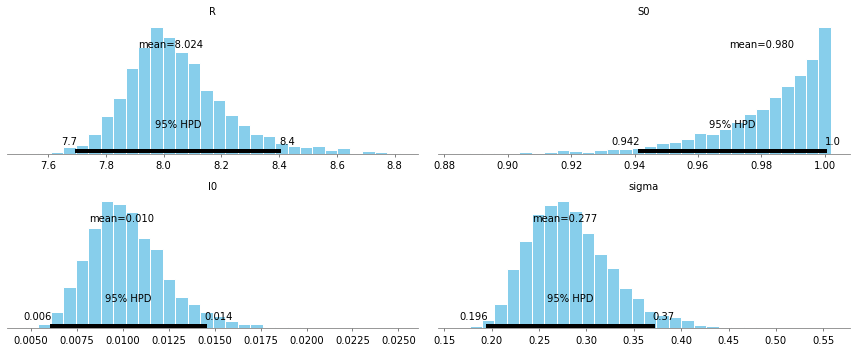

In [6]:
pm.posteriorplot.plot_posterior(trace);


In [7]:
print(pm.gelman_rubin(trace))

print(pm.effective_n(trace))

{'R': 1.0034928403005139, 'S0': 1.002751150364586, 'I0': 1.000362213073982, 'sigma': 1.0004592401788843}
{'R': 675.124848602922, 'S0': 691.8323767577609, 'I0': 2670.1620332486023, 'sigma': 2951.535359062163}


In [8]:
with first_model:
    yppc = pm.sample_ppc(trace)

100%|██████████| 2000/2000 [01:52<00:00, 17.82it/s]


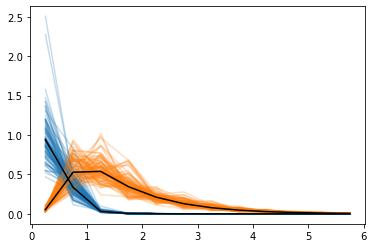

In [9]:
Y_obs  = yppc['Y_obs']

for i in range(100):
    s,i = Y_obs[i].T
    plt.plot(times,s, color = 'C0', alpha = 0.25)
    plt.plot(times,i, color = 'C1', alpha = 0.25)
    
plt.plot(times, sims, color = 'k')